# EDA

## Introduction

## Imports

### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%load_ext line_profiler

### Data import

In [2]:
# Import; parse string timestamp in datetime
# Convert datetime object in granular units for further analysis
df = pd.read_csv('data/load_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].apply(lambda dt: dt.year)
df['month'] = df['timestamp'].apply(lambda dt: dt.month)
df['dom'] = df['timestamp'].apply(lambda dt: dt.day)
df['weekday'] = df['timestamp'].apply(lambda dt: dt.weekday())
df['hour'] = df['timestamp'].apply(lambda dt: dt.hour)
#df['key'] = df.apply(build_cache_key, axis=1)

## Load Profiles

### Weekday profiles by year

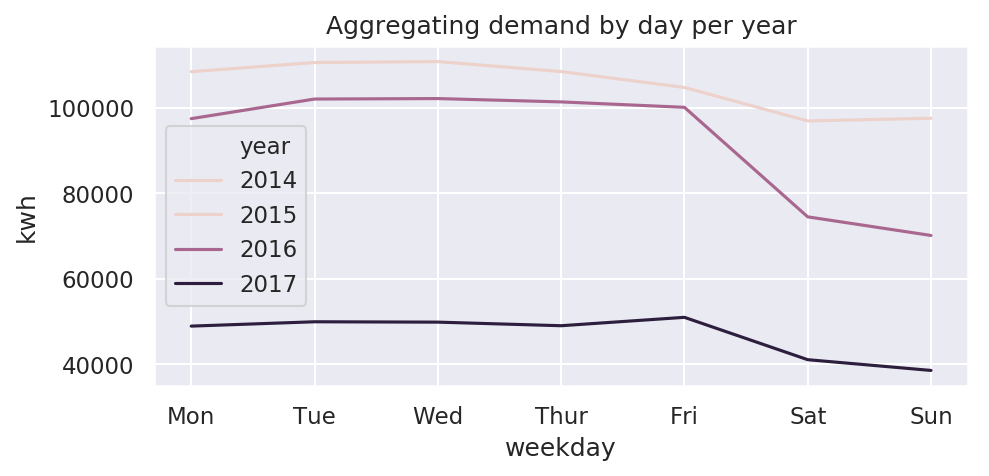

In [3]:
# Groupby by weekday; checking weekly profile across all months
# [0, 1, 2, ...] = [Monday, Tuesday, Wednesday, ...]
weekday_profiles = (df.groupby(['year', 'weekday'])['kwh'].sum()).reset_index()

# Plot settings
fig, ax = plt.subplots(figsize=(7,3),dpi=150)
ax.set_xticklabels(('', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'))
ax.set_title('Aggregating demand by day per year')

# Plot
sns.lineplot(x='weekday', y='kwh', hue='year', data=weekday_profiles, ax=ax);

Profile loads generally exhibit an increasing demand `Monday` through `Wednesday`. Demands began to decrease during `Thursday` and `Friday`. `Saturday` and `Sunday` see lowest values across all years. Optimization targets are weekdays. 

General profile would suggest commercial behavior. Assumed behavior of a residence would be lower consumption through the work week, while resident is at place of employment with higher values on the weekend when resident is more likely to be home.

### Hourly Profiles by day

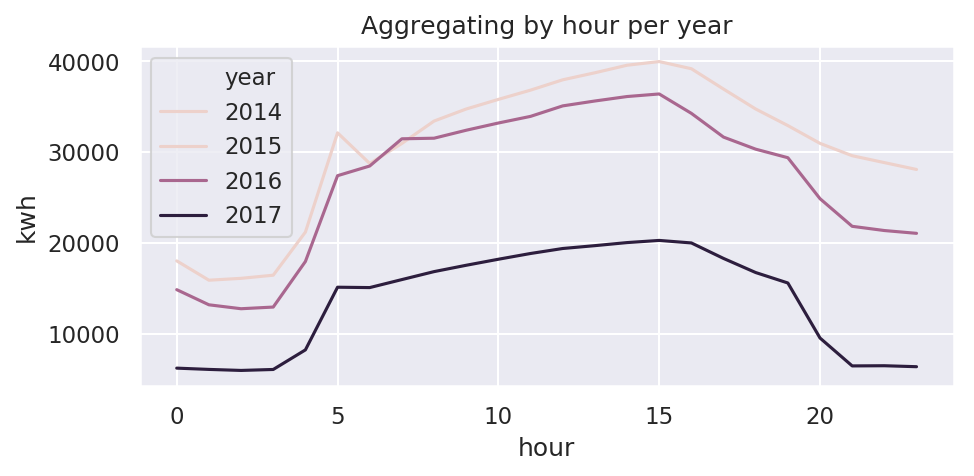

In [4]:
# Group by Year and hour; sum demand by hour
hourly_profiles = (df.groupby(['year', 'hour'])['kwh'].sum()).reset_index()

# Plot settings
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
ax.set_title('Aggregating by hour per year')

# Plot
sns.lineplot(x='hour', y='kwh', hue='year', data=hourly_profiles, ax=ax);

Aggregated hourly loads appear to support commercial assumption from daily aggregate profiles. Consumption begins to climb at 05:00 and peaks near 15:00. Profiles suggest early morning demand adjusting building climate and demans decreasing as both temperatures warm/cool and building is vacated.

### Monthly averages and standard deviation

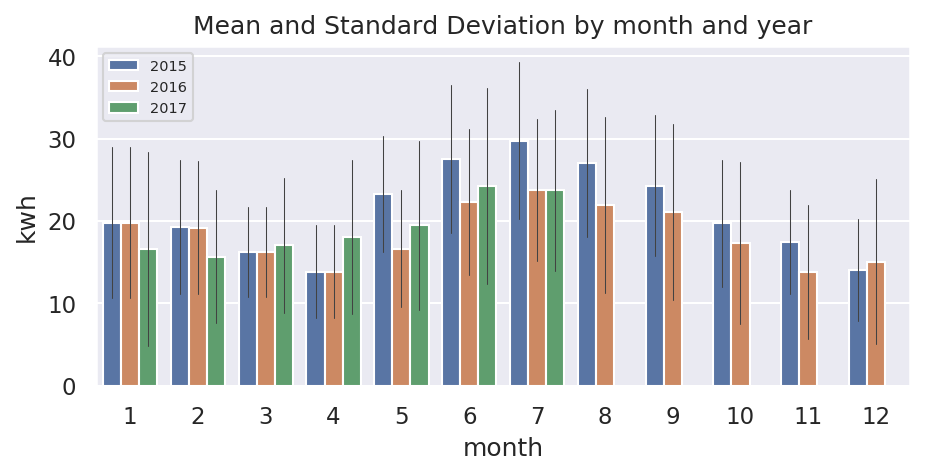

In [5]:
# Plot settings
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
ax.set_title('Mean and Standard Deviation by month and year')

# Plot
sns.barplot(x='month', y='kwh', hue='year', data=df, estimator=np.mean, ci='sd', errwidth=.5)
ax.legend(loc=2, fontsize='x-small');

Averaging the data by month with standard deviation displayed as an uncertainty. General demand trend follows similar patter for all years. 2015 stands outs starting in May and extendng throughout the year.

## Closer look at peaks

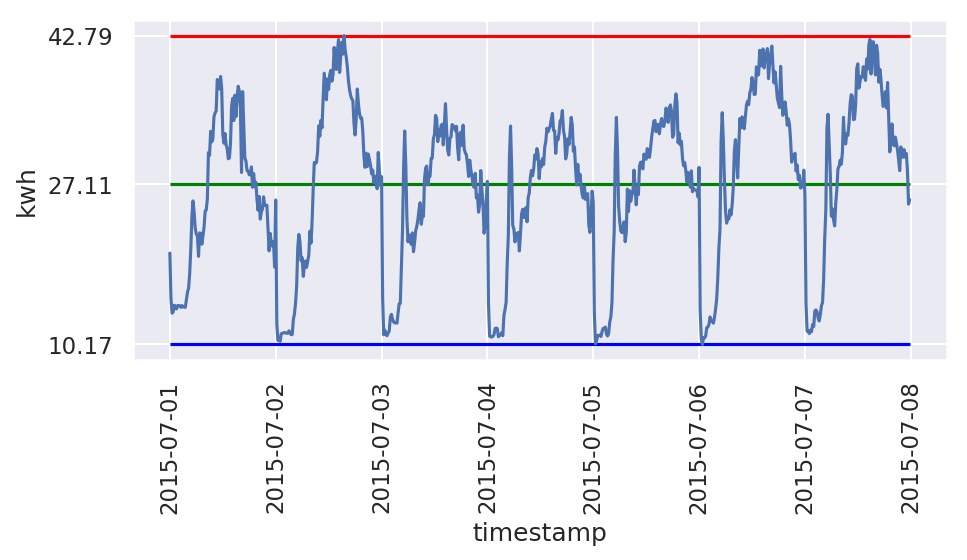

In [6]:
# July 2015; first week; highest average and usage
july15 = df[(df.year == 2015) & (df.month == 7)].copy()
july15['dom'] = july15['timestamp'].apply(lambda x: x.day)

# First week of July
firstWeekJuly = july15[july15.dom <= 7].copy()

# Add a threshold
fig, ax = plt.subplots(figsize=(7, 3), dpi=150)
sns.lineplot(x='timestamp', y='kwh', data=firstWeekJuly, ax=ax)

base_demand = firstWeekJuly.kwh.min()
peak_demand = firstWeekJuly.kwh.max()
mean_demand = firstWeekJuly.kwh.mean()
ax.hlines([base_demand, mean_demand, peak_demand], xmin=firstWeekJuly.timestamp.iloc[0], xmax=firstWeekJuly.timestamp.iloc[-1], color=['blue', 'green', 'red'])
ax.set_yticks([base_demand, mean_demand, peak_demand])

plt.xticks(rotation=90);

The chart above those the first week of July 2015. The three low peaks in the center represent Friday the 4th, Saturday the 5th and Sunday the 6th. If a single threshold is selected for the entire month, peak shaving impacts would be reduced compared to a smart daily dynamic shifts.

Each peak has a characteristic demand spike on the left side. A possible explanation is the building cooling cycle. Cooling demands are reduced at night when the building is not populated. To cool sufficiently before the workday begins, the cooling system must activate and operate near full capacity for a short interval. Once set temperature is reached, energy demands are reduced. As ambient temperatures rise, the systems cooling strives to maintain the building's internal temperature, resulting in the peak demand profile.

# Objective 1 - Peak Shaving

Peak shaving is the process of reducing energy demand peaks through various methods; one of those methods is battery storage. Batteries are set to charge when building demand drop below demand threshold. Once the building demand exceeds that threshold, batteries should discharge. Discharging reduces the energy demand of the building during the most expensive hours of the day.

In [7]:
from peakshave.api.battery import Battery
from peakshave.api.environment import Environment
from peakshave.api.peakshave import daily_battery_strategy, compute_daily_threshold

In [8]:
shaved = list()
count = 0
for k,g in df.groupby(['year', 'month', 'dom']):
    strategy = daily_battery_strategy(g)
    shaved.append(strategy)
shaved = pd.concat(shaved).sort_values(by='timestamp')

/home/miles/miniconda3/envs/powerranger/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


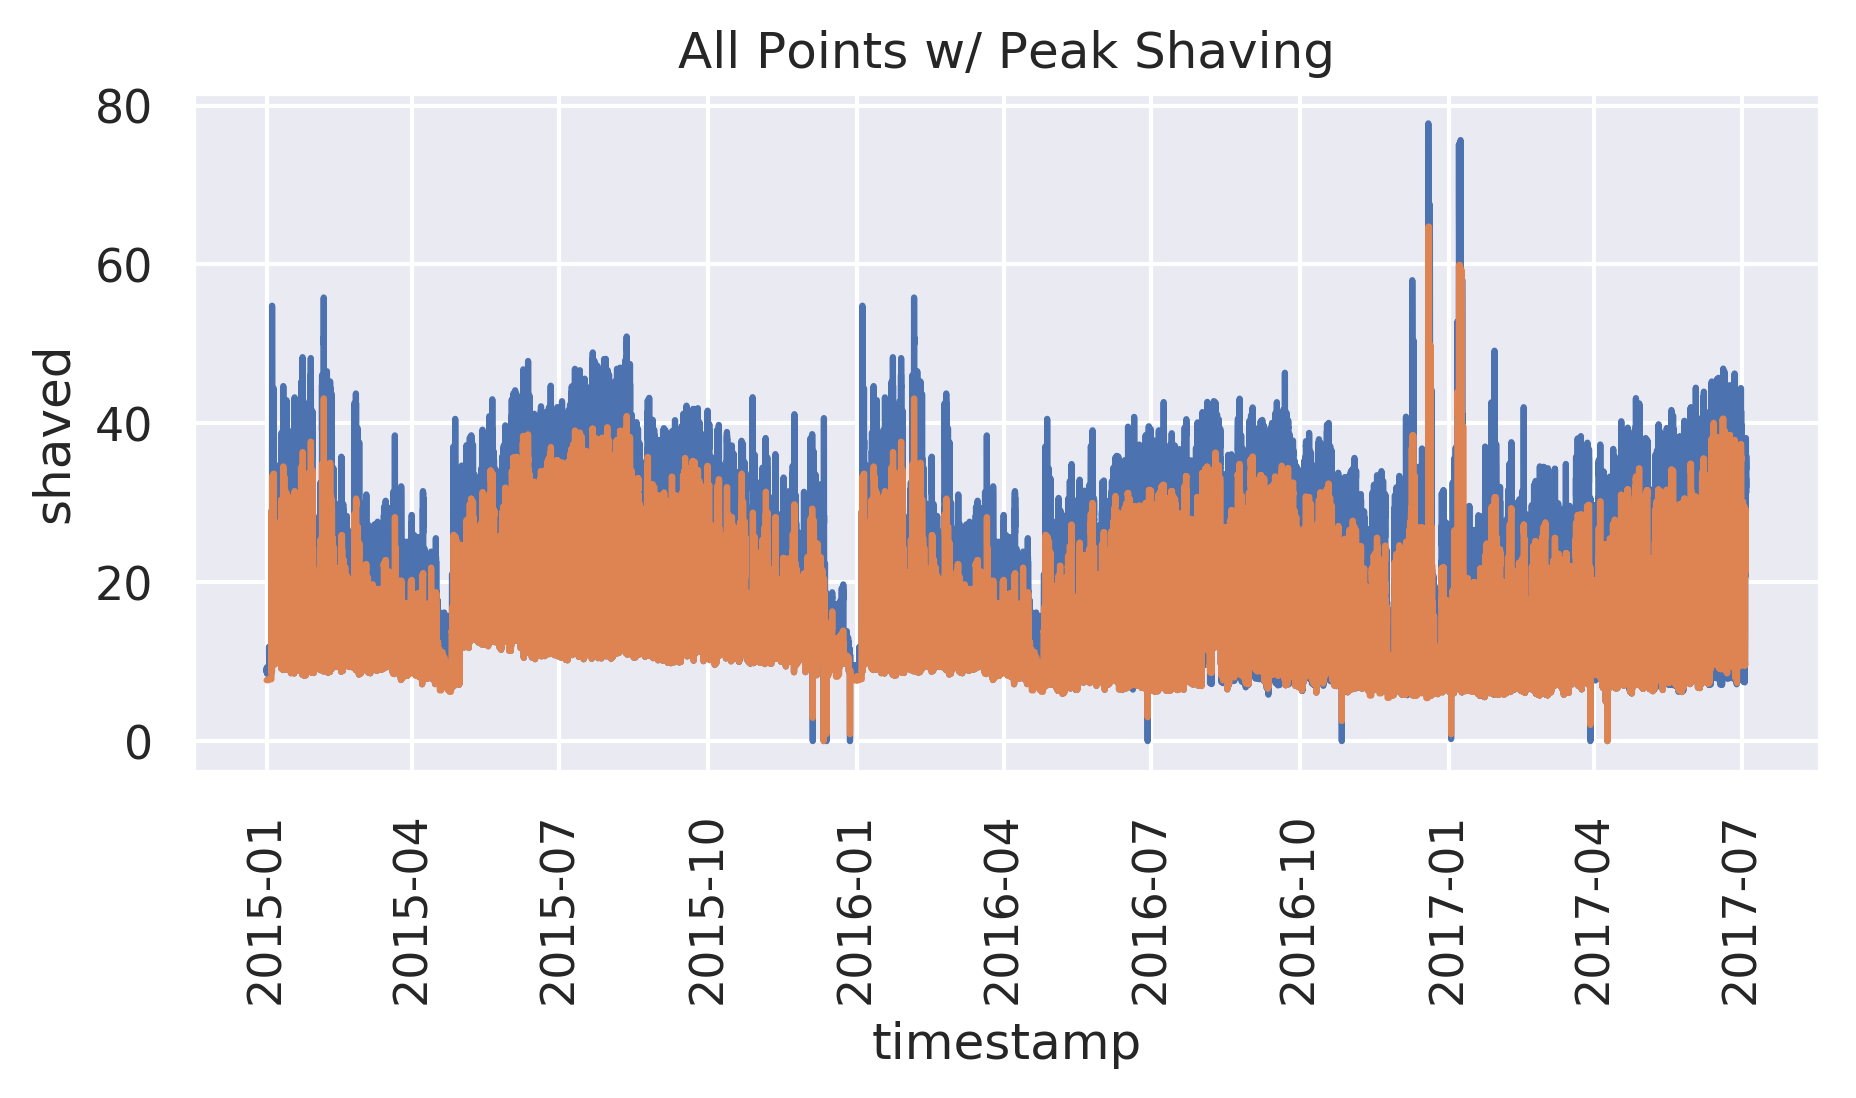

In [9]:
fig, ax = plt.subplots(figsize=(7,3), dpi=300)
sns.lineplot(x='timestamp', y='kwh', ax=ax, data=shaved)
sns.lineplot(x='timestamp', y='shaved', ax=ax, data=shaved)

ax.set_title('All Points w/ Peak Shaving')
plt.xticks(rotation=90);

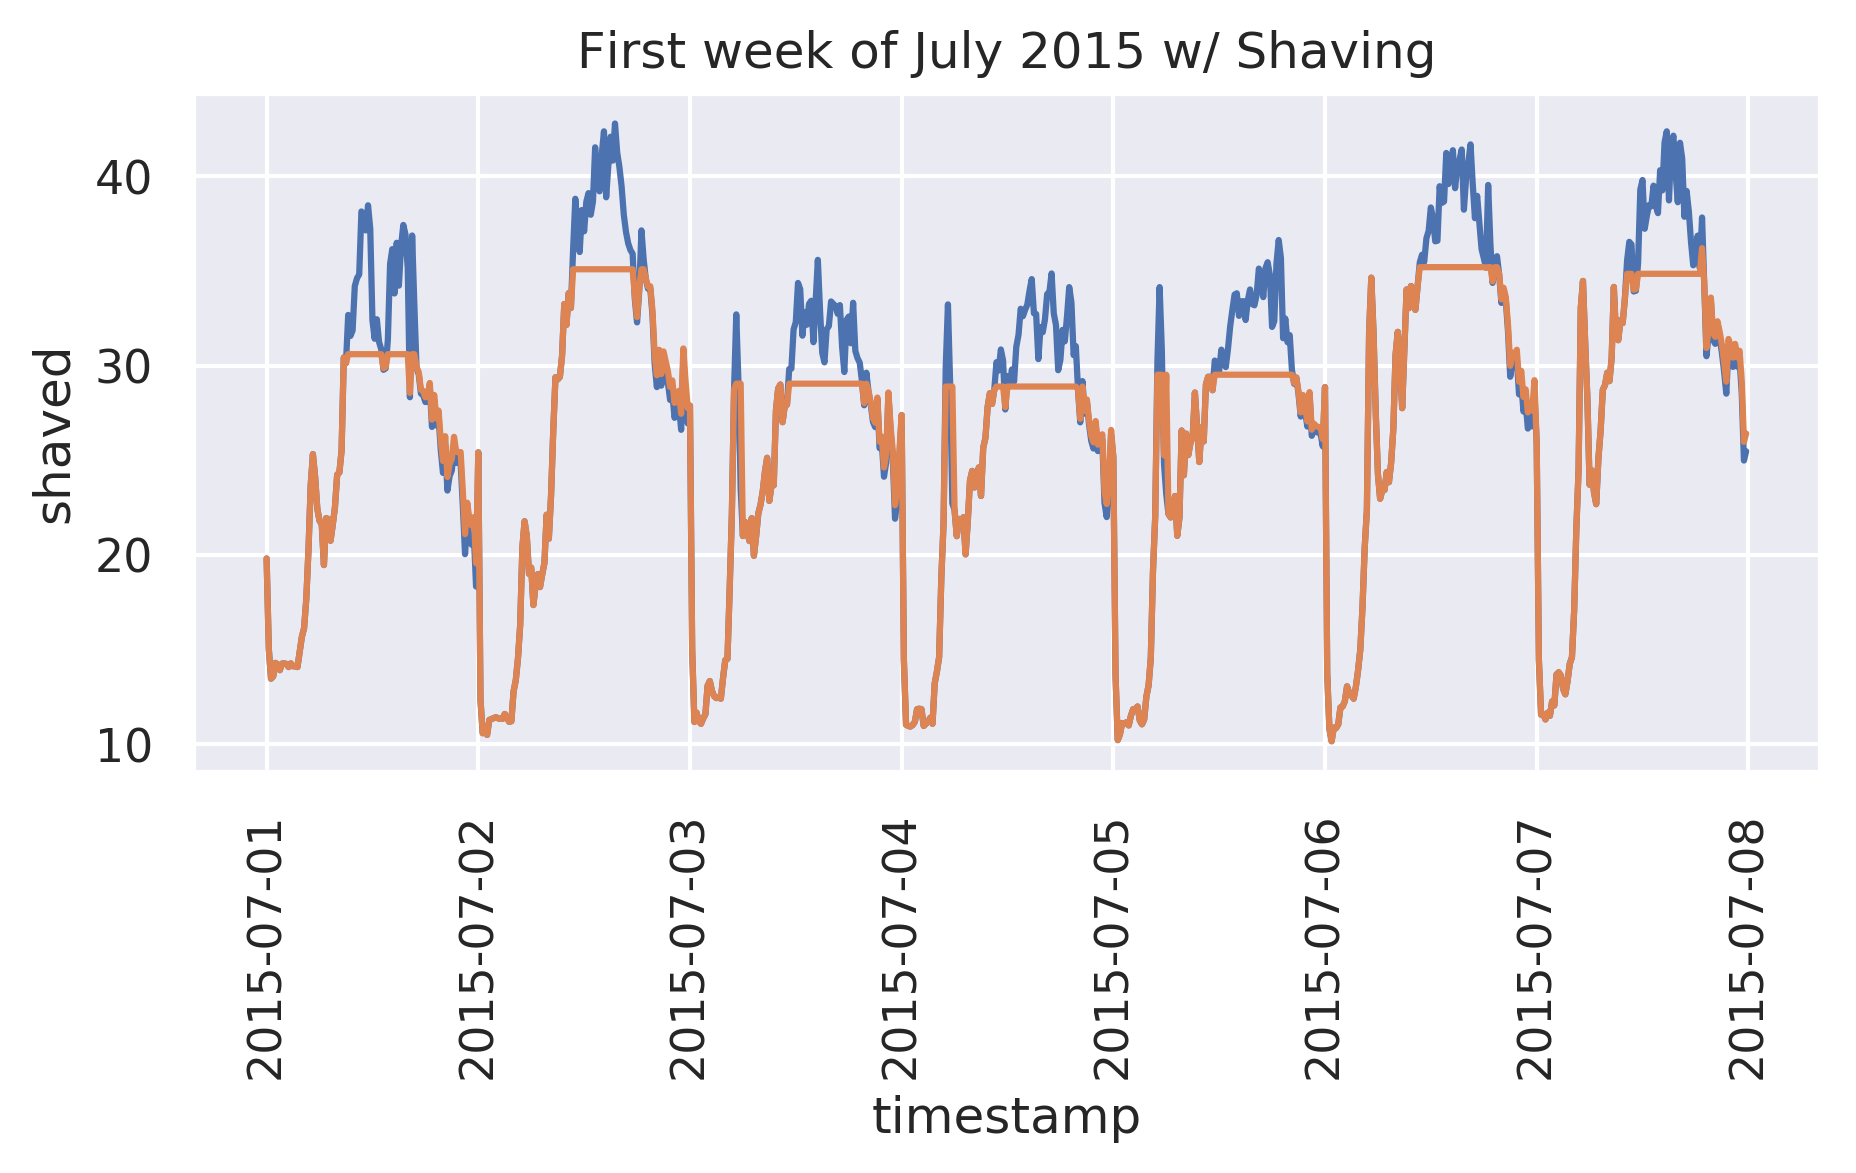

In [17]:
fig, ax = plt.subplots(figsize=(7,3), dpi=300)
july15 = shaved[(shaved.year == 2015) & (shaved.month == 7) & (shaved.dom < 8)]
sns.lineplot(x='timestamp', y='kwh', data=july15)
sns.lineplot(x='timestamp', y='shaved', data=july15)
ax.set_title('First week of July 2015 w/ Shaving')

plt.xticks(rotation=90);

What does the above chart show? Each day a unique threshold has been calculated that best smooths the peak to the threshold.

In [19]:
compare = shaved.groupby(['year', 'month'])[['kwh', 'shaved']].max()
compare['delta%'] = (compare.kwh - compare.shaved) / compare.kwh * 100.0
compare

kwh     shaved     delta%
year month                              
2015 1      54.806  37.686511  31.236524
     2      55.834  43.128077  22.756605
     3      38.477  28.194805  26.722964
     4      40.560  25.962488  35.989920
     5      43.027  34.053999  20.854349
     6      47.846  38.601142  19.322114
     7      48.922  39.506283  19.246387
     8      50.928  40.909030  19.672813
     9      42.221  35.651582  15.559598
     10     43.286  33.667064  22.221818
     11     41.146  31.396783  23.694204
     12     40.656  29.259320  28.031975
2016 1      54.806  37.686511  31.236524
     2      55.834  43.128077  22.756605
     3      38.477  28.194805  26.722964
     4      40.560  25.962488  35.989920
     5      39.120  29.973572  23.380439
     6      40.810  31.635959  22.479886
     7      42.672  33.346109  21.854826
     8      43.104  36.313089  15.754713
     9      46.368  35.820934  22.746432
     10     40.051  32.424917  19.040929
     11     35.645  27.736811  22.185970
     12     77.750  64.740722  16.732190
2017 1      75.648  59.934374  20.772031
     2      42.029  29.282272  30.328412
     3      38.390  29.736577  22.540826
     4      43.171  34.335809  20.465570
     5      42.000  34.906122  16.890187
     6      46.886  40.578340  13.453184
     7      38.150  30.104093  21.090188

# Objective 2 - Battery Capacity

# References

Kutkut, N. Energy Management through Peak Shaving and Demand Response. Energy Management through Peak Shaving and Demand Response Available at: https://act-chargers.com/wp-content/uploads/2017/03/ACT-White-Paper-Energy-Management-through-Peak-Shaving-and-Demand-Response.pdf.